In [1]:
import logging
logging.basicConfig(level=logging.INFO)

import os
import sys
import yaml
import joblib
import pysftp
sys.path.insert(0, "/Users/dhruvlaad/IIT/DDP/DDP/B-SOID/")
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from BSOID.bsoid import *
from BSOID.utils import *
from BSOID.data import *
from BSOID.preprocessing import *
from BSOID.analysis import *
from scipy import ndimage

from getpass import getpass

from sklearn.cluster import SpectralClustering
from itertools import combinations

import scipy
from scipy.spatial.distance import squareform

from eac import coassociation_matrix

import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from copy import deepcopy
%matplotlib notebook

/Users/dhruvlaad/anaconda3/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [2]:
SAVE_DIR = "/Users/dhruvlaad/IIT/DDP/data/paper/"
FIG1_SAVEDIR = os.path.join(SAVE_DIR, "figure1")
FIG2_SAVEDIR = os.path.join(SAVE_DIR, "figure2")
FIG3_SAVEDIR = os.path.join(SAVE_DIR, "figure3")
DDP_SAVEDIR = os.path.join(SAVE_DIR, "ddpplots")
for fdir in [FIG1_SAVEDIR, FIG2_SAVEDIR, FIG3_SAVEDIR, DDP_SAVEDIR]:
    try: os.mkdir(fdir)
    except FileExistsError: pass
    
LABEL_INFO_FILE = "/Users/dhruvlaad/IIT/DDP/data/finals/label_info.sav"
MAX_LABEL = 61

In [3]:
def load_label_info():
    with open(LABEL_INFO_FILE, "rb") as f:
        label_info = joblib.load(f)
    return label_info

def get_transition_matrix(strain=None, exclude_strains=None, n=None, ns=None):
    if strain is None:
        strain_tmat = transition_matrix_across_strains(load_label_info(), MAX_LABEL)
        if exclude_strains is not None:
            for strain in exclude_strains:
                del strain_usage[strain]
    else:
        strain_tmat = {strain: [{"tmat": transition_matrix(d["labels"], MAX_LABEL)} for d in load_label_info()[strain]]}

    tmats = []
    for _, data in strain_tmat.items():
        tmats.extend([d["tmat"] for d in data])
    
    tmats = np.array(tmats)
    if n is not None and ns is not None:
        tmats = bootstrap_estimate(tmats, n, ns)[0]
    
    return tmats        
        
def get_usage(strain=None, exclude_strains=None, n=None, ns=None):
    if strain is None:
        strain_usage = proportion_usage_across_strains(load_label_info(), MAX_LABEL)
        if exclude_strains is not None:
            for strain in exclude_strains:
                del strain_usage[strain]
    else:
        strain_usage = {strain: [{"prop": proportion_usage(d["labels"], MAX_LABEL)} for d in load_label_info()[strain] ]}

    usage = []
    for _, data in strain_usage.items():
        usage.extend([d["prop"] for d in data])
    
    usage = np.vstack(usage)
    if n is not None and ns is not None:
        usage = bootstrap_estimate(usage, n, ns)
    
    return usage

# Figure 1
---

## Keypoints on Frame

In [ ]:
def likelihood_filter_no_hour_trim(data, fps, conf_threshold, bodyparts):
    N = data.shape[0]

    # retrieve confidence, x and y data from csv data
    conf, x, y = [], [], []
    for col in data.columns:
        if col.endswith('_lh'):
            conf.append(data[col])
        elif col.endswith('_x'):
            x.append(data[col])
        elif col.endswith('_y'):
            y.append(data[col])
    conf, x, y = np.array(conf).T, np.array(x).T, np.array(y).T
    conf, x, y = conf[:,bodyparts], x[:,bodyparts], y[:,bodyparts]
    
    # take average of nose and ears
    conf = np.hstack((conf[:,:3].mean(axis=1).reshape(-1,1), conf[:,3:]))
    x = np.hstack((x[:,:3].mean(axis=1).reshape(-1,1), x[:,3:]))
    y = np.hstack((y[:,:3].mean(axis=1).reshape(-1,1), y[:,3:]))

    n_dpoints = conf.shape[1]
    
    filt_x, filt_y = np.zeros_like(x), np.zeros_like(y)

    points_filtered_by_idx = np.zeros((n_dpoints,))
    for i in range(n_dpoints):    
        j, perc_filt = 0, 0

        while j < N and conf[j,i] < conf_threshold:
            perc_filt += 1
            j += 1
        
        filt_x[0:j,i] = np.repeat(x[j, i], j)
        filt_y[0:j,i] = np.repeat(x[j, i], j)
        prev_best_idx = j

        for j in range(j, N):
            if conf[j,i] < conf_threshold:
                filt_x[j,i] = x[prev_best_idx,i]
                filt_y[j,i] = y[prev_best_idx,i]
                perc_filt += 1
            else:
                filt_x[j,i], filt_y[j,i] = x[j,i], y[j,i]
                prev_best_idx = j

        points_filtered_by_idx[i] = perc_filt
    
    x, y, conf = filt_x, filt_y, conf
    perc_filt = points_filtered_by_idx.max()
    
    return {'conf': conf, 'x': x, 'y': y}, perc_filt * 100 / N

def download_video_and_keypt_data(input_csv, config_file, strain=None):
    save_dir = os.path.join(FIG1_SAVEDIR, "frame_keypoint_fig")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    df = pd.read_csv(input_csv)
    if strain is not None:
        df = df[df["Strain"] == strain]
    
    done = False
    session = ftplib.FTP("ftp.box.com")
    password = getpass("Box login password: ")
    session.login("ae16b011@smail.iitm.ac.in", password)
    while not done:
        try:
            data = dict(df.iloc[np.random.randint(0, df.shape[0], 1)[0]])
            data_fname, vid_fname = get_video_and_keypoint_data(session, data, save_dir)
            done = True
        except Exception as e:
            session.quit()
            session = ftplib.FTP("ftp.box.com")
            password = getpass("Box login password: ")
            session.login("ae16b011@smail.iitm.ac.in", password)
    
    print(f"Extracting data from {os.path.join(save_dir, data_fname)}")
    conf, pos = process_h5py_data(h5py.File(os.path.join(save_dir, data_fname)))
    bsoid_data = bsoid_format(conf, pos)
    
    with open(config_file, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    fdata, perc_filt = likelihood_filter_no_hour_trim(bsoid_data, fps=30, conf_threshold=0.3, bodyparts=config["bodyparts"])

    shape = fdata['x'].shape
    print(f'Preprocessed {shape} data, with {round(perc_filt, 2)}% data filtered')

    with open(os.path.join(save_dir, "rawdata.pkl"), "wb") as f:
        joblib.dump(fdata, f)

def get_frames_from_video(n=10):
    save_dir = os.path.join(FIG1_SAVEDIR, "frame_keypoint_fig")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    
    with open(os.path.join(save_dir, "rawdata.pkl"), "rb") as f:
        keypoints = joblib.load(f)
    x, y = keypoints['x'], keypoints['y']

    assert x.shape[0] == y.shape[0]
    N = x.shape[0]

    idxs = np.random.randint(0, N, n)
    idxs.sort()
    x, y = x[idxs], y[idxs]

    count, frames = 0, []
    
    video_file = [os.path.join(save_dir, f) for f in os.listdir(save_dir) if f.endswith(".avi")][0]
    video = cv2.VideoCapture(video_file)
    success, image = video.read()
    while success:
        if count in idxs:
            frames.append(image)
        count += 1

        success, image = video.read()
    
    assert count == N, f"# of frames ({count}) in video does not match with # of keypoint-datapoints ({N})"

    for i, f in enumerate(frames):
        cv2.imwrite(os.path.join(save_dir, f"frame{i}.jpg"), f)
    
    with open(os.path.join(save_dir, "keypointdata.pkl"), "wb") as f:
        joblib.dump([x, y], f)
        
def keypoint_plot(image_file, keypoint_data_file, idx, deg=0, xlim=None, ylim=None):
    save_dir = os.path.join(FIG1_SAVEDIR, "frame_keypoint_fig")
    with open(keypoint_data_file, "rb") as f:
        x, y = joblib.load(f)
    
    x, y = x[idx], y[idx]

    HEAD, BASE_NECK, CENTER_SPINE, HINDPAW1, HINDPAW2, BASE_TAIL, MID_TAIL, TIP_TAIL = np.arange(8)
    link_connections = ([BASE_TAIL, CENTER_SPINE],
                        [CENTER_SPINE, BASE_NECK],
                        [BASE_NECK, HEAD],
                        [BASE_TAIL, HINDPAW1], [BASE_TAIL, HINDPAW2],
                        [BASE_TAIL, MID_TAIL],
                        [MID_TAIL, TIP_TAIL])
    
    fig, ax = plt.subplots()
    img = ndimage.rotate(plt.imread(image_file), deg)
    ax.imshow(img, extent=[0, img.shape[0], 0, img.shape[1]])
    
    for link in link_connections:
        h, t = link
        plt.plot([x[h], x[t]], [y[h], y[t]], linewidth=2, color="y")
    
    cmap = mpl.cm.get_cmap("tab20")
    for idx in np.arange(8):
        plt.scatter(x[idx], y[idx], color=cmap(idx), s=30)
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
    
    plt.savefig(os.path.join(save_dir, "keypoint_plot.jpg"), bbox_inches="tight", pad_inches=0)
    fig.show()

    fig, ax = plt.subplots()
    img = ndimage.rotate(plt.imread(image_file), deg)
    ax.imshow(img, extent=[0, img.shape[0], 0, img.shape[1]])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
    plt.savefig(os.path.join(save_dir, "original_image.jpg"), bbox_inches="tight", pad_inches=0)

In [ ]:
# needs to be run only once
input_csv = "D:/IIT/DDP/data/paper/MergedMetaList_2019-04-18_strain-survey-mf-subset.csv"
download_video_and_keypt_data(input_csv, config_file="../config/config.yaml")

In [ ]:
# run till desirable frame is received
get_frames_from_video(n=10)

In [ ]:
# run once to generate keypoint plot
idx = 3
image_file = os.path.join(FIG1_SAVEDIR, "frame_keypoint_fig", f"frame{idx}.jpg")
keypoint_file = os.path.join(FIG1_SAVEDIR, "frame_keypoint_fig", "keypointdata.pkl")
keypoint_plot(image_file, keypoint_file, idx, deg=90, xlim=200, ylim=200)

# centroid velocity and corresponding behaviours

In [31]:
def get_metadata_for_plot(data_dir, label_info_file, config_file):
    save_dir = os.path.join(FIG1_SAVEDIR, "centroid_velocity_fig")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    
    with open(label_info_file, "rb") as f:
        label_info = joblib.load(f)
    strain = random.sample(list(label_info.keys()), 1)[0]
    data = random.sample(label_info[strain], 1)[0]
    metadata, labels = data["metadata"], data["labels"]
    
    del label_info
    print("getting raw data from JAX database...")
    
    pose_dir, _ = get_pose_data_dir(data_dir, metadata["NetworkFilename"])
    _, _, movie_name = metadata['NetworkFilename'].split('/')
    filename = f"{pose_dir}/{movie_name[0:-4]}_pose_est_v2.h5".replace('\\', '/')
    password = getpass("JAX ssh login password: ")
    with pysftp.Connection('login.sumner.jax.org', username='laadd', password=password) as sftp:
        sftp.get(filename)
    print(f"Extracted: {filename}")
    
    with open(config_file, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        
    filename = f"{movie_name[0:-4]}_pose_est_v2.h5"
    conf, pos = process_h5py_data(h5py.File(filename, "r"))
    data = bsoid_format(conf, pos)
    fdata, perc_filt = likelihood_filter(data, config["fps"], config["conf_threshold"], config["bodyparts"], end_trim=5, clip_window=-1)
    if perc_filt > 10:
        strain, mouse_id = metadata['Strain'], metadata['MouseID']
        print(f'mouse:{strain}/{mouse_id}: % data filtered from raw data is too high ({perc_filt} %)')
    
    if labels.size < fdata['x'].shape[0]:
        print(f"# of labels ({labels.size}) not equal to # of datapoints ({fdata['x'].shape[0]})")
        fdata['x'], fdata['y'] = fdata['x'][:labels.size], fdata['y'][:labels.size]
    
    keypoints = {'x': fdata['x'], 'y': fdata['y'], "labels": labels}
    
    with open(os.path.join(save_dir, "metadata.pkl"), "wb") as f:
        joblib.dump(keypoints, f)
    
    os.remove(filename)
    
def plot_centroid_velocity(fps, tspan=None):
    save_dir = os.path.join(FIG1_SAVEDIR, "centroid_velocity_fig")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    
    with open(os.path.join(save_dir, "metadata.pkl"), "rb") as f:
        metadata = joblib.load(f)
    
    from BSOID.preprocessing import smoothen_data
    centroid_idx = 2
    x, y = metadata['x'][:,centroid_idx], metadata['y'][:,centroid_idx]
    x, y = smoothen_data(x, 10), smoothen_data(y, 10)
    x, y = (x[1:] - x[0:-1]) * 0.0264 / (1 / fps), (y[1:] - y[0:-1]) * 0.0264 / (1 / fps)
    x, y = x/100, y/100
    vel = np.sqrt(x ** 2 + y ** 2)
    
    def plot_time_series(vel, fps, final=False):
        t = np.arange(vel.shape[0])
        fig, ax = plt.subplots(figsize=(12,2.5))
        ax.plot(t, vel, color="k", linewidth=1)
        ax.set_ylim([-0.01*vel.max(), 1.1 * vel.max()])
        ax.set_xlim([0, t.max() + 1])
        if final:
            ax.set_xticks([t.max() + 1])
            ax.set_xticklabels([f"{int(t.max() / fps)} seconds"], fontsize=10)
        ax.set_yticks([0, vel.max()])
        ax.set_yticklabels(["0", f"{round(vel.max(), 2)} m/s"])
        ax.yaxis.tick_right()
        ax.tick_params(axis=u'both', which=u'both',length=0)
        for _, spine in ax.spines.items():
            spine.set_visible(False)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "centroid_velocity.jpg"), bbox_inches="tight", pad_inches=0.5)
        plt.show()
      
    if tspan is None:
        plot_time_series(vel, fps)
    else:
        plot_time_series(vel[tspan[0]:tspan[1]], fps, final=True)     

In [23]:
metadata['x'].shape

(80996, 8)

<IPython.core.display.Javascript object>


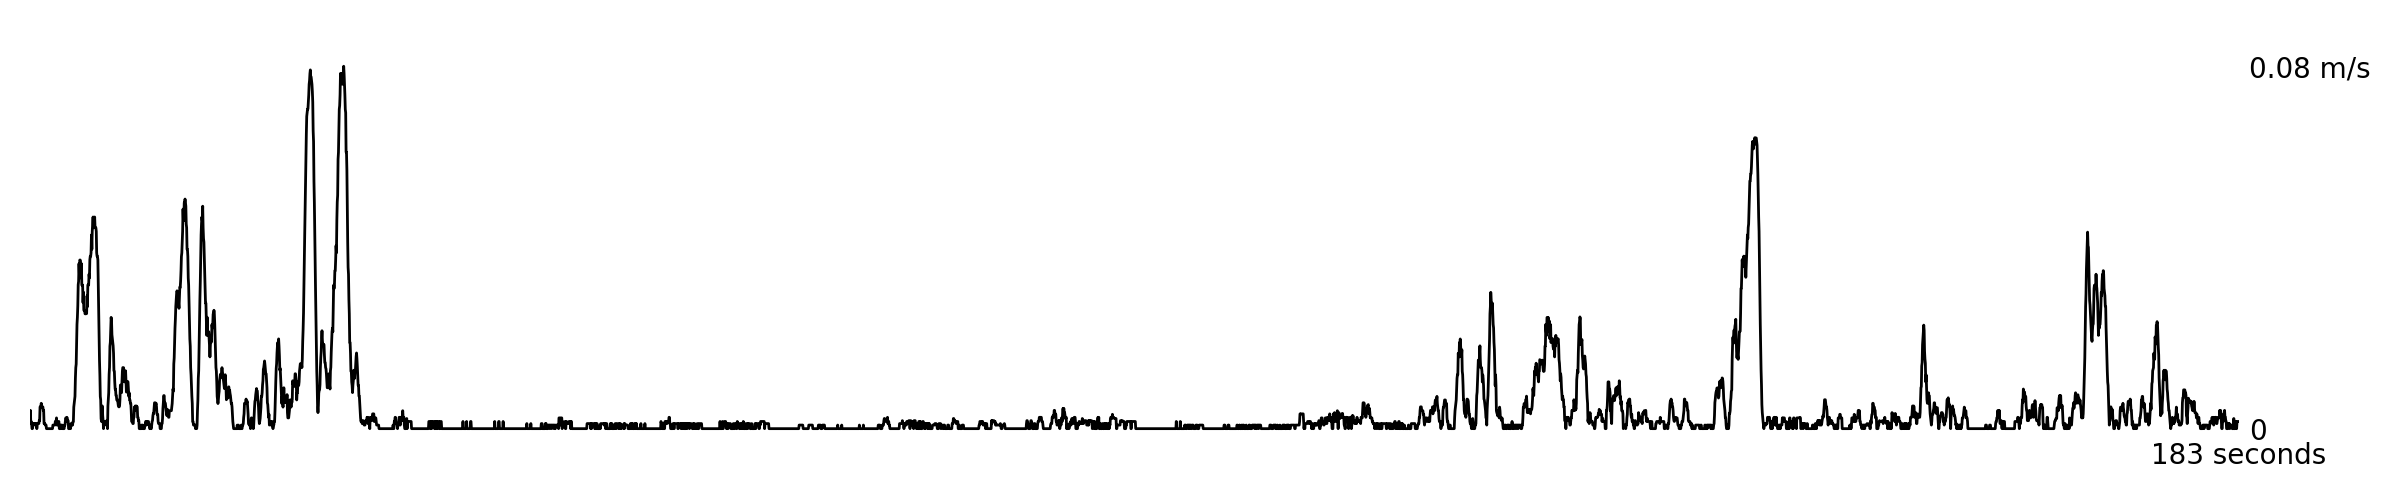

In [34]:
data_dir = "/projects/kumar-lab/StrainSurveyPoses"
label_info_file = '/Users/dhruvlaad/IIT/DDP/data/finals/label_info.sav'
config_file = "../config/config.yaml"
# get_metadata_for_plot(data_dir, label_info_file, config_file)

tspan = None
tspan = [64500, 70000]
plot_centroid_velocity(30, tspan)

## ethrogram corresponding to centroid velocity plot

In [40]:
def ethogram_plot(tspan, fps, inv_group_map, group_names):
    save_dir = os.path.join(FIG1_SAVEDIR, "ethogram_fig")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    
    cmap = mpl.cm.get_cmap('tab20')

    with open(os.path.join(FIG1_SAVEDIR, "centroid_velocity_fig", "metadata.pkl"), "rb") as f:
        metadata = joblib.load(f)
    
    labels = metadata["labels"][tspan[0]:tspan[1]]
    height, N = 1, len(labels)
    
    labels = np.array([inv_group_map[l] for l in labels])

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 3), gridspec_kw={'height_ratios': [1, 2.75]})
    i, pat = 0, []
    while i < len(labels):
        j = i + 1
        while j < len(labels) and labels[i] == labels[j]:
            j += 1
        pat.append(patches.Rectangle((i, 0), (j - i + 1), height, color=cmap(labels[i])))
        i = j
    
    [ax[0].add_patch(p) for p in pat]
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    for _, spine in ax[0].spines.items():
        spine.set_visible(False)
    ax[0].set_xlim([0, N])
    ax[0].set_ylabel("Ethogram", fontsize=10)

    height = 0.5
    k, ylocs = 0, {}
    for idx in np.unique(labels):
        lab = group_names[idx]
        if idx not in ylocs:
            ylocs[idx] = (k*(height + 0.1), lab)
            k += 1
    
    i, pat = 0, []
    while i < len(labels):
        j = i + 1
        while j < len(labels) and labels[i] == labels[j]:
            j += 1
        y = ylocs[labels[i]][0]
        pat.append(patches.Rectangle((i, y), (j - i + 1), height, color=cmap(labels[i])))
        i = j    

    [ax[1].add_patch(p) for p in pat]
    ax[1].set_xlim([0, N])
    ax[1].set_ylim([0 - 0.1, (k+1)*(height+0.1) - 0.1])

    for _, lab in ylocs.items():
        y = lab[0] + (height / 2)
        ax[1].plot(np.arange(N), y * np.ones((N,)), color='gray', linestyle='-', linewidth=0.77, alpha=0.1)
    ax[1].set_yticks([lab[0] + (height / 2) for _, lab in ylocs.items()])
    ax[1].set_yticklabels([lab[1] for _, lab in ylocs.items()], fontsize=9)
    ax[1].yaxis.tick_right()
    ax[1].set_ylabel("Phenotypes", fontsize=10)
    ax[1].set_xticks([N])
    ax[1].set_xticklabels([f"{int((tspan[1] - tspan[0]) / fps)} seconds"], fontsize=10)
    ax[1].tick_params(axis=u'both', which=u'both',length=0)
    for _, spine in ax[1].spines.items():
        spine.set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "ethogram_plot.jpg"), bbox_inches="tight", pad_inches=0, dpi=600)
    plt.show()

<IPython.core.display.Javascript object>


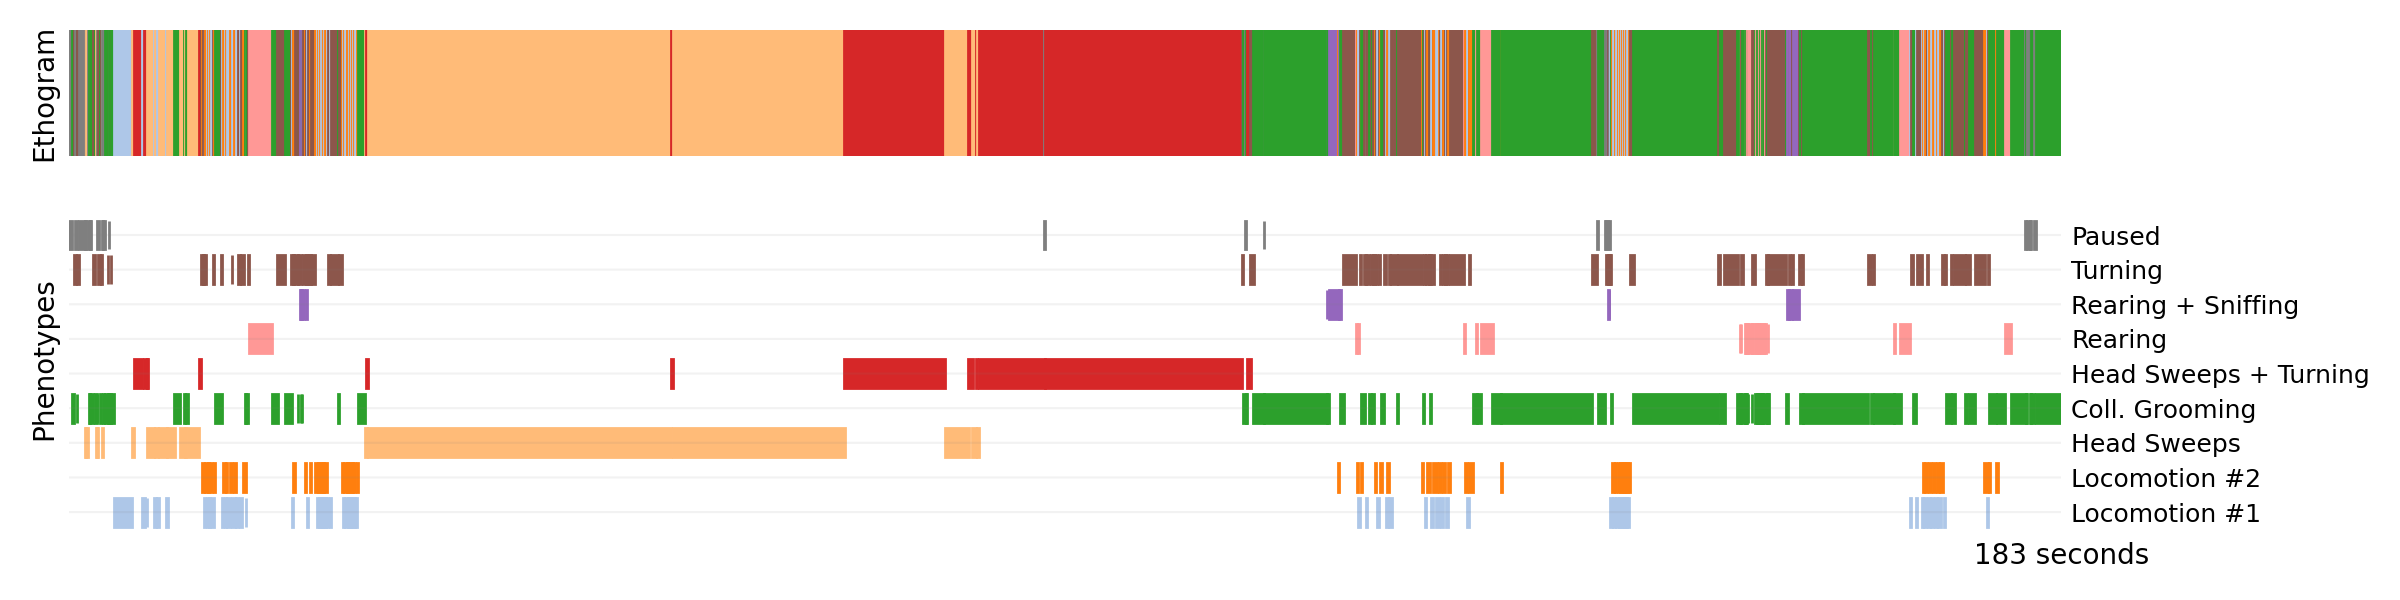

In [44]:
group_map, inv_group_map, group_labels = custom_group()
ethogram_plot(tspan, 30, inv_group_map, group_labels)

# Figure 2
---

## proportion usage plots

In [ ]:
def behaviour_usage_plot(label_info_file, max_label, n=30, ns=250):
    save_dir = os.path.join(FIG2_SAVEDIR, "behaviour_usage_figure")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    
    with open(label_info_file, "rb") as f:
        label_info = joblib.load(f)
    
    strain_props = proportion_usage_across_strains(label_info, max_label)
    props = []
    for strain, data in strain_props.items():
        for d in data:
            props.append(d["prop"])
    props = np.vstack(props)
    
    prop_mean = props.mean(axis=0)
    prop_stds = bootstrap_estimate(props, ns=ns, n=n)
    idx = np.argsort(-prop_mean)
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.errorbar(
        x=np.arange(prop_mean.size), 
        y=prop_mean[idx], 
        yerr=prop_stds[idx], 
        fmt="-k", 
        ecolor=(0.59, 0.59, 0.61, 0.85), 
        elinewidth=4.5, 
        capsize=4,
        linewidth=3
    )
    ax.set_xlabel('Sorted Phenotypes', fontsize=18)
    ax.set_ylabel('Proportion Usage', fontsize=18)
    ax.set_ylim([0, 1.1 * (prop_mean[idx[0]] + prop_stds[idx[0]])])
    sns.despine(trim=True)
    ax.tick_params(axis='x', labelrotation=0, labelsize=14)
    plt.savefig(os.path.join(save_dir, "behaviour_usage_plot.jpg"), dpi=300, bbox_inches='tight', pad_inches=0)
    fig.show()
    
    prop = {"Strain": []}
    for i in range(max_label):
        prop[f"prop {i}"] = []
        
    for strain, data in strain_props.items():
        for d in data:
            if "BTBR" in strain:
                strain = "$\mathregular{BTBR T^+ Itpr3^{tf}/J}$"
            prop["Strain"].append(strain)
            [prop[f"prop {i}"].append(d["prop"][i]) for i in range(max_label)]
    prop = pd.DataFrame.from_dict(prop)
    usage = prop.groupby("Strain").median().T
    ax = sns.heatmap(usage, xticklabels=True, yticklabels=True, cbar_kws={"pad": 0.01}, cmap="hot")
    plt.gcf().set_size_inches(15.5, 4)
    ax.set_xlabel('')
    ax.set_ylabel("Phenotypes", fontsize=13)
    ax.set_yticks(range(0, max_label, 10))
    ax.tick_params(axis='x', labelsize=10)
    ax.set_yticklabels(range(0, max_label, 10))
    plt.savefig(os.path.join(save_dir, "strainwise_usage_plot.jpg"), dpi=400, bbox_inches='tight', pad_inches=0)
    plt.show() 

In [ ]:
label_info_file = "/Users/dhruvlaad/IIT/DDP/data/finals/label_info.sav"
behaviour_usage_plot(label_info_file, max_label=61, n=30, ns=250)

## vignettes

In [17]:
def download_video_file(label_info_file, config_file, strain=None):
    save_dir = os.path.join(FIG2_SAVEDIR, "vignette_figure")
    try: os.mkdir(save_dir)
    except FileExistsError: pass

    with open(label_info_file, "rb") as f:
        info = joblib.load(f)

    if strain:
        data = info[strain]
    else:
        data = info[random.sample(list(info.keys()), 1)[0]]
    data = random.sample(data, 1)[0]
    metadata, labels = data["metadata"], data["labels"]
    
    passwd = getpass("Box login password: ")
    session = ftplib.FTP("ftp.box.com")
    session.login("ae16b011@smail.iitm.ac.in", passwd)
    data_fname, vid_fname = get_video_and_keypoint_data(session, metadata, save_dir)
    data_fname, vid_fname = os.path.join(save_dir, data_fname), os.path.join(save_dir, vid_fname)
    
    conf, pos = process_h5py_data(h5py.File(os.path.join(save_dir, data_fname)))
    data = bsoid_format(conf, pos)
    with open(config_file, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    fdata, perc_filt = likelihood_filter(data, fps=config["fps"], conf_threshold=0.3, bodyparts=config["bodyparts"], end_trim=5, clip_window=-1)

    shape = fdata['x'].shape
    print(f'Preprocessed {shape} data, with {round(perc_filt, 2)}% data filtered')
    
    os.remove(data_fname)
    data_fname = data_fname.replace(".csv", ".pkl")
    with open(data_fname, "wb") as f:
        joblib.dump(fdata, f)

    metadata["data_fname"] = data_fname
    metadata["vid_fname"] = vid_fname
    metadata["labels"] = labels

    with open(os.path.join(save_dir, "metadata.pkl"), "wb") as f:
        joblib.dump(metadata, f)
    
def save_frames_and_loc_data(behaviour_idx, min_bout_len, fps, n=10):
    save_dir = os.path.join(FIG2_SAVEDIR, "vignette_figure")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
     
    min_bout_len = min_bout_len * fps // 1000
    
    with open(os.path.join(save_dir, "metadata.pkl"), "rb") as f:
        metadata = joblib.load(f)
    video_file = os.path.join(save_dir, metadata["vid_fname"])
    with open(os.path.join(save_dir, metadata["data_fname"]), "rb") as f:
        fdata = joblib.load(f)
    labels = metadata["labels"]

    save_dir = os.path.join(save_dir, f"phenotype_{behaviour_idx}_clips")
    try: os.mkdir(save_dir)
    except FileExistsError: pass

    i, locs = 0, []

    while i < len(labels):
        if labels[i] == behaviour_idx:
            j = i + 1
            while j < len(labels) and (labels[j] == labels[i]):
                j += 1
            
            if (j - i + 1) >= min_bout_len:
                locs.append([i, j, (j - i + 1)])

            i = j
        else:
            i += 1
    
    locs = sorted(locs, key=lambda x: x[-1], reverse=True)[:n]
    locs = sorted(locs, key=lambda x: x[0])

    count, i = 0, 0
    video = cv2.VideoCapture(video_file)
    success, image = video.read()
    while success and locs:
        if i == locs[0][0]:
            clip_dir = os.path.join(save_dir, f"clips_{count}")
            try: os.mkdir(clip_dir)
            except FileExistsError: pass

            k = 0
            while success and i <= locs[0][1]:
                cv2.imwrite(os.path.join(clip_dir, f"phenotype_{behaviour_idx}_frame_{k}.jpg"), image)
                success, image = video.read()
                k, i = k + 1, i + 1


            start_idx, end_idx = locs[0][:-1]
            x, y = fdata['x'][start_idx:end_idx], fdata['y'][start_idx:end_idx]

            with open(os.path.join(clip_dir, "keypoint_data.pkl"), "wb") as f:
                joblib.dump([x, y], f)
            
            del locs[0]
            count += 1
        else:
            i += 1
            success, image = video.read()

def skeletal_plot(ax, x, y, weight):
    HEAD, BASE_NECK, CENTER_SPINE, HINDPAW1, HINDPAW2, BASE_TAIL, MID_TAIL, TIP_TAIL = np.arange(8)
    link_connections = ([BASE_TAIL, CENTER_SPINE],
                        [CENTER_SPINE, BASE_NECK],
                        [BASE_NECK, HEAD],
                        [BASE_TAIL, HINDPAW1], [BASE_TAIL, HINDPAW2],
                        [BASE_TAIL, MID_TAIL],
                        [MID_TAIL, TIP_TAIL])
    
    cmap = mpl.cm.get_cmap("YlGnBu")
    for link in link_connections:
        h, t = link
        ax.plot([x[h], x[t]], [y[h], y[t]], linewidth=3, color=cmap(weight), alpha=0.5)

    for i in np.arange(8):
        ax.scatter(x[i], y[i], s=20, color=cmap(weight), alpha=0.5)
    
    return ax, cmap

def make_vignettes(behaviour_idx, clip_no, idxs, ske_idxs, weights, img_crop=None, skeletal_crop=None, deg=0):
    assert sum(weights) == 1, "weights must sum to 1"    
    save_dir = os.path.join(FIG2_SAVEDIR, "vignette_figure")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    
    frame_dir = os.path.join(save_dir, f"phenotype_{behaviour_idx}_clips", f"clips_{clip_no}")
    frames = [os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith(".jpg")]
    frames.sort(key=lambda x: int(x.split('_')[-1][:-4]))

    behaviour = frame_dir.split('/')[-3].split("_")[0]

    frames = [cv2.imread(frames[i]) for i in idxs]

    img = sum(f * w for f, w in zip(frames, weights)) / 255.0
    img = ndimage.rotate(img, deg)

    fig, ax = plt.subplots(ncols=2, gridspec_kw={"width_ratios": [1, 1]})

    ax[0].imshow(img, extent=[0, img.shape[0], 0, img.shape[1]])
    ax[1].imshow(img, extent=[0, img.shape[0], 0, img.shape[1]])

    with open(os.path.join(frame_dir, "keypoint_data.pkl"), "rb") as f:
        x, y = joblib.load(f)

    for i, idx in enumerate(ske_idxs):
        wt = (idx - min(ske_idxs))/(max(ske_idxs) - min(ske_idxs))
        ax[1], cmap = skeletal_plot(ax[1], x[idx], y[idx], wt)

    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set_ylim(ax[0].get_ylim())
    
    cax = fig.add_axes([0.57, 0.90, 0.15, 0.05])
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, orientation="horizontal", ticks=[0.0, 1.0])
    cax.set_xticks([0.0, 1.0])
    cax.set_xticklabels(["start", "end"])
    cax.tick_params(axis=u'both', which=u'both',length=0)

    for _, spine in cax.spines.items():
        spine.set_visible(False)

    for (ax_, lims) in zip(ax, [img_crop, skeletal_crop]):
        ax_.set_xlim(lims[0])
        ax_.set_ylim(lims[1])

    for ax_ in ax:
        ax_.set_xticklabels([])
        ax_.set_yticklabels([])
        ax_.set_axis_off()
        ax_. set_aspect('equal')
        ax_.set_anchor('N')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{behaviour}_fig.jpg"), dpi=400, bbox_inches="tight", pad_inches=0)
    plt.show()

In [18]:
label_info_file = "/Users/dhruvlaad/IIT/DDP/data/finals/label_info.sav"
config_file = "../config/config.yaml"
download_video_file(label_info_file, config_file, strain="C57BL/6J")

Box login password: ········
Downloading: WT001G2N21616F-16-PSY_pose_est_v2.h5
Downloading: WT001G2N21616F-16-PSY.avi


/Users/dhruvlaad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


Preprocessed (81000, 8) data, with 0.54% data filtered


In [24]:
save_frames_and_loc_data(behaviour_idx=6, min_bout_len=200, fps=30, n=2)

## Behavioral Metrics Plots

In [42]:
def custom_group():
    group_map, inv_group_map, group_labels = get_group_map("/Users/dhruvlaad/IIT/DDP/data/finals/eac_mat.npy", pvalue=0.53)
    
    groom_labels = [
        "Grooming", 
        "Stationary Grooming", 
        "Posterior Grooming #1", 
        "Posterior Grooming #2",
        "Sniffing + Grooming",
        "Reared Grooming #1",
        "Reared Grooming #2"
    ]
    
    groom_group_idx = [idx for idx, lab in group_labels.items() if lab in groom_labels]
    new_groom_idx = min(groom_group_idx)
    
    groom_motifs = []
    for idx in groom_group_idx:
        groom_motifs.extend(group_map[idx])
        del group_map[idx]
        del group_labels[idx]
    group_map[new_groom_idx] = groom_motifs
        
    for motif in groom_motifs:
        inv_group_map[motif] = new_groom_idx
    
    group_labels[new_groom_idx] = "Grooming"
    
    return group_map, inv_group_map, group_labels

In [ ]:
def compile_stats(stats, group_labels):
    stats_df = {"MouseID": [], "Sex": [], "Strain": [], "NetworkFilename": []}
    
    phenos = [int(pheno.split('_')[1]) for pheno in stats[list(stats.keys())[0]] if "td" in pheno]
    for i in phenos:
        for met in ["TD", "ABL", "NB"]:
            stats_df[f"{group_labels[i]}-{met}"] = []
    
    for key, data in stats.items():
        mouse_id, sex, strain, nfname = key.split(';')

        stats_df["MouseID"].append(mouse_id)
        stats_df["Sex"].append(sex)
        stats_df["Strain"].append(strain)
        stats_df["NetworkFilename"].append(nfname)
        
        for i in phenos:
            stats_df[f"{group_labels[i]}-TD"].append(data[f"phenotype_{i}_td"])
            stats_df[f"{group_labels[i]}-ABL"].append(data[f"phenotype_{i}_abl"])
            stats_df[f"{group_labels[i]}-NB"].append(data[f"phenotype_{i}_nb"])
    
    stats_df = pd.DataFrame.from_dict(stats_df)
    
    btbr_rows = stats_df.index[stats_df["Strain"].str.contains("BTBR")]
    stats_df.loc[btbr_rows, "Strain"] = "$\mathregular{BTBR T^+ Itpr3^{tf}/J}$"
    
    return stats_df

def plot_metric(df, ax=None):
    _, _, datacol = df.columns
    
    metric = datacol.split('-')[-1]
    axis_labels = {"TD": "Total Duration (min)", "ABL": "Average Bout Length (s)", "NB": "Number of Bouts"}
    
    if metric == "TD":
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            df.loc[:,datacol] = df[datacol] / 60
        
    gdfs = df.groupby("Strain")
    metric_data_mean = gdfs[datacol].mean().sort_values()
    order = list(metric_data_mean.index)

    if ax is None:
        fig, ax = plt.subplots()
        
    sns.stripplot(x='Strain', y=datacol, data=df, hue='Sex', jitter=False, order=order, ax=ax)
    ax.tick_params(grid_color='gray', grid_alpha=0.3, labelrotation=90, labelsize=8)
    ax.grid(True)
    ax.set_ylabel(axis_labels[metric], fontsize=12)
    ax.set_xlabel(None)
    ax.tick_params(axis='y', labelrotation=0, labelsize=8)

    maxy, rect_width = 0, 0.5
    metric_data_std = gdfs[datacol].std().loc[order]
    for j in range(metric_data_mean.shape[0]):
        rect_height, mean = metric_data_std[j], metric_data_mean[j]
        rect_bottom_left = (j - (rect_width / 2), max(mean - rect_height, 0))
        if mean - rect_height < 0:
            rect_size = (rect_width, mean)
        else:
            rect_size = (rect_width, rect_height)
        ax.add_patch(plt.Rectangle(rect_bottom_left, *rect_size, edgecolor='k', linewidth=1.2, fill=False, zorder=1000))

        rect_bottom_left = (j - (rect_width / 2), mean)
        rect_size = (rect_width, rect_height)
        ax.add_patch(plt.Rectangle(rect_bottom_left, *rect_size, edgecolor='k', linewidth=1.2, fill=False, zorder=1000))
        
        maxy = max(maxy, rect_bottom_left[1] + rect_size[1])
        
    ax.figure.set_size_inches(10, 2)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_ylim([-0.1, 1.1*maxy])
    if metric == "TD":
        ax.legend(loc="upper left")
    else:
        ax.get_legend().set_visible(False)

    return ax
        
def plot_all_behavioral_metrics():
    save_dir = os.path.join(FIG3_SAVEDIR, "behavioural_metrics")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    
    group_map, inv_group_map, group_labels = custom_group()
    stats = bout_stats_for_all_strains(load_label_info(), MAX_LABEL, min_bout_len=200, fps=30, inv_group_map=inv_group_map)
    stats_df = compile_stats(stats, group_labels)
    
    for _, behaviour in group_labels.items():
        print(f"Plotting for: {behaviour}", end="\x1b[1K\r")
        for metric in ["TD", "ABL", "NB"]:
            ax = plot_metric(stats_df[["Strain", "Sex", f"{behaviour}-{metric}"]])
            plt.savefig(os.path.join(save_dir, f"{behaviour}-{metric}.jpg"), dpi=500, pad_inches=0, bbox_inches="tight")
            plt.close()

In [ ]:
plot_all_behavioral_metrics()

# Figure 3
---
## PVE Estimates

In [4]:
def pve_estimates(pve_estimates_file):
    with open(pve_estimates_file, 'r') as f:
        pve_data = f.readlines()

    pve_df = {"Phenotype": [], "PVE": [], "PVESE": [], "Vg": [], "Ve": [], "Group": []}
    for data in pve_data[1:]:
        phen, pve, pve_se, vg, ve = data.split(',')
        pve_df["Phenotype"].append(phen)
        pve_df["PVE"].append(float(pve))
        pve_df["PVESE"].append(float(pve_se))
        pve_df["Vg"].append(float(vg))
        pve_df["Ve"].append(float(ve[:-1]))
        
        if "abl" in phen:
            group = "Average Bout Length"
        elif "td" in phen:
            group = "Total Duration"
        elif "nb" in phen:
            group = "Number of Bouts"
        pve_df["Group"].append(group)
        
    pve_df = pd.DataFrame.from_dict(pve_df)
    pve_df.sort_values(by="PVE", axis=0, inplace=True)
    return pve_df

def pve_plot(pve_estimates_file):
    pve = pve_estimates(pve_estimates_file)
    
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.barplot(y="PVE", x="Phenotype", orient='v', data=pve, hue="Group", yerr=pve["PVESE"].values, ax=ax, dodge=False)
    ax.set_xticklabels([])
    plt.legend(loc="upper left", prop={'size': 8})
    sns.despine(trim=True, offset=1)
    plt.savefig(os.path.join(FIG3_SAVEDIR, "pve_plot.jpg"), dpi=400, pad_inches=0, bbox_inches="tight")
    plt.show()
    
    return pve

<IPython.core.display.Javascript object>


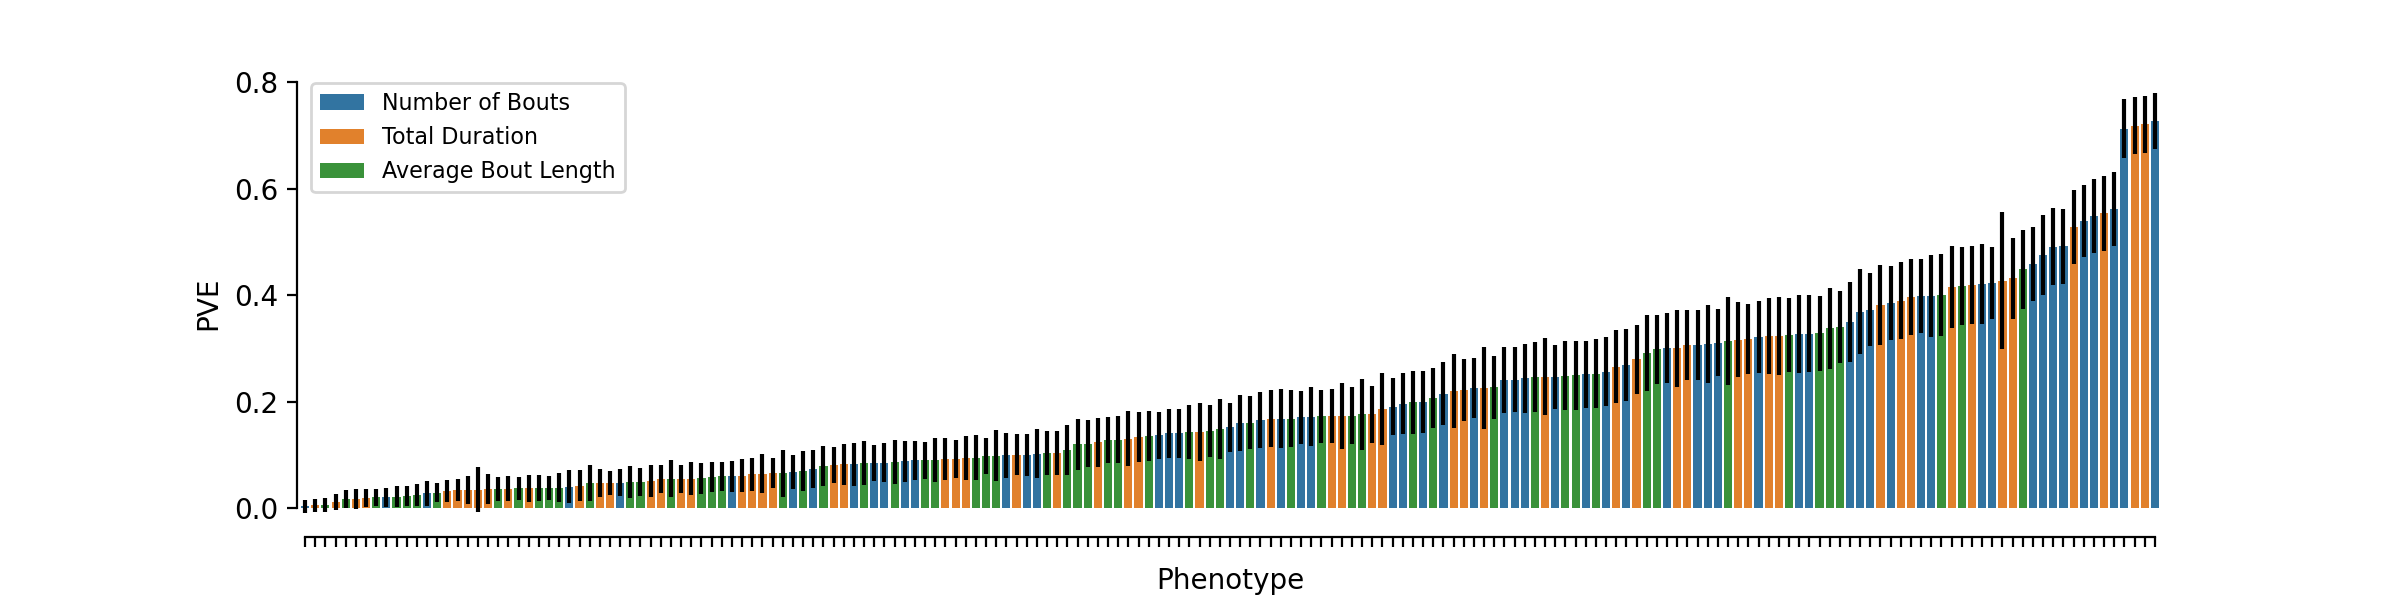

,Phenotype,PVE,PVESE,Vg,Ve,Group
155,phenotype_56_td,0.554191,0.070588,0.873879,0.471431,Total Duration
154,phenotype_56_nb,0.562622,0.069449,0.874873,0.456102,Number of Bouts
118,phenotype_45_nb,0.712807,0.055095,1.059390,0.286243,Number of Bouts
164,phenotype_59_td,0.718646,0.053410,1.132920,0.297450,Total Duration
119,phenotype_45_td,0.721211,0.053793,1.102130,0.285707,Total Duration
163,phenotype_59_nb,0.726927,0.052935,1.137190,0.286482,Number of Bouts


In [5]:
pve_estimates_file = "/Users/dhruvlaad/IIT/DDP/data/gwas/downsampled/PVE_GEMMA_estimates.txt"
pve = pve_plot(pve_estimates_file)
pve.iloc[-6:]

In [7]:
pve[pve["PVE"] > 0.2].shape[0], pve.shape[0]

(72, 183)

## Transition Matrix (Hinton Diagram)

In [ ]:
def hinton(matrix, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    ax.patch.set_facecolor('white')
    ax.set_aspect('equal', 'box')

    max_weight = 0.15
    for (x, y), w in np.ndenumerate(matrix):
        color = (0.1, 0.44, 0.82)
        if w > max_weight:
            color = (0.96, 0.26, 0.71)
            w = max_weight / 6
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

#     ax.autoscale_view(tight=True)
    ax.invert_yaxis()
    
    b1, = ax.plot([], marker='s', markersize=2.0, linestyle='', color = (0.96, 0.26, 0.71), label=f"p > {max_weight}")
    b2, = ax.plot([], marker='s', markersize=3.75, linestyle='', color=(0.1, 0.44, 0.82), label=f"p = {max_weight}")

    leg = ax.legend(handles=[b1, b2], bbox_to_anchor=(0.95, 0.98), title="Transition\nProbability", borderpad=0.2, handletextpad=0.05, prop={'size': 7})
    leg.get_frame().set_linewidth(0.0)
    leg.get_title().set_fontsize('8')
    return ax

def spectral_reordering_tmat(tmat, groups=4):
    labels = SpectralClustering(affinity='precomputed', n_clusters=groups).fit_predict(tmat)

    groups = [[] for x in range(labels.max()+1)]
    for i, x in enumerate(labels):
        groups[x].append(i)
        
    new_ordering = []
    for g in groups:
        new_ordering.extend(g)
    
    spectral_tmat = tmat.copy()
    spectral_tmat = spectral_tmat[:,new_ordering]
    spectral_tmat = spectral_tmat[new_ordering,:]
    
    return spectral_tmat

def hinton_diagram_transition_matrix_plot(label_info_file, max_label, groups=6, strain=None):
    with open(label_info_file, "rb") as f:
        label_info = joblib.load(f)

    print("Hinton Diagram Plot:")
    print("\t (1) Extracting transition matrices for each animal")
    strain_tmats = transition_matrix_across_strains(label_info, max_label)
    del label_info

    tmat = np.zeros((max_label, max_label))
    if strain is not None:
        for mat in strain_tmats[strain]:
            tmat += matmat["tmat"]
        tmat /= len(strain_tmats[strain])
    else:
        N = 0
        for _, mats in strain_tmats.items():
            for mat in mats:
                tmat += mat["tmat"]
                N += 1

        tmat /= N
    del strain_tmats

    print(f"\t (2) Reording transition matrix (groups={groups})")
    tmat = spectral_reordering_tmat(tmat, groups)
    
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax = hinton(tmat, ax)
    sns.despine(trim=True)
    
    plt.savefig(os.path.join(FIG3_SAVEDIR, "transition_matrix.jpg"), dpi=500, bbox_inches="tight", pad_inches=0)
    plt.show()

In [ ]:
hinton_diagram_transition_matrix_plot(label_info_file="/Users/dhruvlaad/IIT/DDP/data/finals/label_info.sav", max_label=61, groups=6)

## Behavioral Statemaps

In [ ]:
def tnet_from_tmat(tmat, plot_props):        
    G = nx.MultiDiGraph()
    G.add_nodes_from(range(0, tmat.shape[0]))
    
    for i in range(tmat.shape[0]):
        for j in range(tmat.shape[1]):
            if i != j and np.abs(tmat[i,j]) > plot_props["min_thresh"]:
                G.add_edge(i, j, weight=tmat[i,j])
    
    return G
        
def behavioural_statemap_for_strain(plot_props, tmat=None, prop=None, strain=None, n=None, ns=None):
    tmat = get_transition_matrix(strain=strain, n=n, ns=ns) if tmat is None else tmat
    prop = get_usage(strain=strain, n=n, ns=ns)[0] if prop is None else prop

    G = tnet_from_tmat(tmat, plot_props)
    return G, tmat, prop

def draw_statemap(G, prop, plot_props, ax=None, savefile=None, pos=None, return_pos=False, legend=False):
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    edge_wts, edge_bins = plot_props["edge_wgts"], plot_props["edge_bins"]
    widths = [edge_wts[np.digitize([G[u][v][0]['weight']], edge_bins)[0]] for u, v in G.edges()]
    alphas = [plot_props["alphas"][np.digitize([G[u][v][0]['weight']], edge_bins)[0]] for u, v in G.edges()]
    
    edges = [G[u][v][0]['weight'] for u, v in G.edges()]
    edge_colors = [tuple([*plot_props["color"], alphas[i]]) for i in range(len(edges))]
        
    if pos is None:
        pos = generate_statemap_layout(G, plot_props)

    nx.draw(G, ax=ax, pos=pos, node_size=2000*prop, connectionstyle='bar, fraction = 0.01', edge_color=edge_colors, edgecolors='k', node_color='white', width=widths, arrowsize=5)
    if legend:
        ax = add_legend(ax, plot_props)
    
    if savefile is not None:
        plt.savefig(os.path.join(FIG3_SAVEDIR, savefile), dpi=400, pad_inches=0, bbox_inches="tight")
    plt.show()
    
def draw_diff_state_plot(graph1, graph2, plot_props, pos=None, ax=None, savefile=None, legend=False):
    G1, tmat1, prop1 = graph1
    G2, tmat2, prop2 = graph2
    
    tmatdiff, propdiff = tmat1 - tmat2, prop1 - prop2
    Gdiff, _, _ = behavioural_statemap_for_strain(tmat=tmatdiff, prop=propdiff, plot_props=plot_props)

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))
    
    edge_wts, edge_bins = plot_props["edge_wgts"], plot_props["edge_bins"]
    widths = [edge_wts[np.digitize([Gdiff[u][v][0]['weight']], edge_bins)[0]] for u, v in Gdiff.edges()]
    alphas = [plot_props["alphas"][np.digitize([Gdiff[u][v][0]['weight']], edge_bins)[0]] for u, v in Gdiff.edges()]
    
    edges = [Gdiff[u][v][0]['weight'] for u, v in Gdiff.edges()]
    edge_colors = []
    for i, e in enumerate(edges):
        if e < 0:
            color = tuple([*plot_props["neg_color"], alphas[i]])
        else:
            color = tuple([*plot_props["pos_color"], alphas[i]])
        edge_colors.append(color)
    
    node_colors, edgecolors = [], []
    max_node_colors, min_node_colors = [], []
    for p in propdiff:
        if p < 0:
            color = [*plot_props["neg_color"], 0.7]
        else:
            color = [*plot_props["pos_color"], 0.7]
        node_colors.append(tuple(color))
        
        color[-1] = 1.0
        edgecolors.append(tuple(color))
        
        if p < 0:
            max_node_colors.append(color)
            min_node_colors.append('k')
        else:
            max_node_colors.append('k')
            min_node_colors.append(color)
        
    node_sizes = np.vstack((prop1, prop2))

    if pos is None:
        pos = generate_statemap_layout(Gdiff, plot_props)
    if legend:
        ax = add_legend(ax, plot_props)
        
    nx.draw(Gdiff, ax=ax, pos=pos, node_size=2000*node_sizes.max(axis=0), connectionstyle='bar, fraction = 0.01', edge_color=edge_colors, edgecolors=max_node_colors, node_color=node_colors, width=widths, arrowsize=5)
    nx.draw_networkx_nodes(Gdiff, ax=ax, pos=pos, node_size=2000*node_sizes.min(axis=0), node_color="white", edgecolors=min_node_colors)
    
    if savefile is not None:
        plt.savefig(os.path.join(FIG3_SAVEDIR, savefile), dpi=400, pad_inches=0, bbox_inches="tight")
    plt.show()

In [ ]:
plot_props = {
    "edge_wgts": [0, 0.5, 1.5, 5],
    "edge_bins": [0.01, 0.045, 0.075],
    "color": (0.071, 0.247, 0.631),
    "alphas": [0, 0.1, 0.5, 0.7],
    "min_thresh": 0.0025
}

diff_plot_props = {
    "edge_wgts": [2.5, 1.5, 0.5, 0, 0.5, 1.5, 2.5],
    "edge_bins": [-0.05, -0.025, -0.005, 0.005, 0.025, 0.05],
    "pos_color": (0.071, 0.247, 0.631),
    "neg_color": (0.741, 0.106, 0.059),
    "alphas": [0.7, 0.5, 0.1, 0, 0.1, 0.5, 0.7],
    "min_thresh": 0.001
}

In [ ]:
# Gall, tmatall, propall = behavioural_statemap_for_strain(plot_props=plot_props)
pos = draw_statemap(Gall, propall, plot_props, return_pos=True)

In [ ]:
strain1, strain2 = "C57BL/6J", "MSM/MsJ"
G1, tmat1, prop1 = behavioural_statemap_for_strain(strain=strain1, plot_props=plot_props, n=25, ns=500)
G2, tmat2, prop2 = behavioural_statemap_for_strain(strain=strain2, plot_props=plot_props, n=15, ns=500)

In [ ]:
def generate_statemap_layout(tmat, thresh):
    G = nx.Graph()
    G.add_nodes_from(range(0, tmat.shape[0]))
    
    for i, j in combinations(range(tmat.shape[0]), 2):
        if i != j and abs(tmat[i,j]) > thresh:
            wt = 1 if tmat[i,j] > 0 else -1
            G.add_edge(i, j, weight=wt)
    pos = nx.spectral_layout(G)
    
    for u, v in G.edges():
        if G[u][v]["weight"] != 0:
            G[u][v]["weight"] = max(abs(tmat[u,v]), abs(tmat[v,u]))
            
    pos = nx.spring_layout(G, pos=pos, k=0.1)
    return pos

def add_legend(ax, plot_props):
    import matplotlib.patches as mpatches
    from matplotlib.lines import Line2D
    if "pos_color" in plot_props:
        colors = [plot_props["neg_color"], plot_props["neg_color"], plot_props["pos_color"], plot_props["pos_color"]]
        labels = [f"-{round(abs(val)*100, 1)}%" for val in plot_props["edge_bins"][:2]]
        labels.extend([f"+{round(val*100, 1)}%" for val in plot_props["edge_bins"][4:]])
        sizes = [5, 1.5, 1.5, 5]
        correction = [0, 0.9, 0.9, 0]
    else:
        colors = [plot_props["color"]] * 3
        labels = [f"+{round(val*100, 1)}%" for val in plot_props["edge_bins"]]
        sizes = [0.5, 2, 5]
    
    colors = [list(c) + [1.0] for c in colors]
    patches = [Line2D([0], [0], label=labels[i],color=colors[i],linewidth=sizes[i]) for i in range(len(labels))]
    leg = ax.legend(handles=patches, bbox_to_anchor=(0.05, 0.75), loc='lower left', labelspacing=0.25, frameon=False, title='Transition\nProbability', prop={'size': 7})
    plt.setp(leg.get_title(),fontsize=7)
    return ax

In [ ]:
pos = generate_statemap_layout(tmat1 - tmat2, 0.01)
# draw_statemap(G1, prop1, plot_props, savefile="c57bl6j_statemap.jpg", return_pos=True, legend=True, pos=pos)
# draw_statemap(G2, prop2, plot_props, savefile="casteij_statemap.jpg", pos=pos)
draw_diff_state_plot([G1, tmat1, prop1], [G2, tmat2, prop2], plot_props=diff_plot_props, savefile="diff_statemap.jpg", pos=pos, legend=True)

## Statemap Scatter Plot

In [ ]:
def diff_plot(strain1, strain2, ax):
    G1, tmat1, prop1 = behavioural_statemap_for_strain(strain=strain1, plot_props=plot_props)
    G2, tmat2, prop2 = behavioural_statemap_for_strain(strain=strain2, plot_props=plot_props)
        
    pos = nx.spring_layout(G1, pos=nx.spectral_layout(G1))
    draw_diff_state_plot([G1, tmat1, prop1], [G2, tmat2, prop2], plot_props=diff_plot_props, pos=pos, savefile="diff_statemap.jpg", ax=ax)
    return ax

def statemap_scatter_plot(nrows=7, ncols=4):
    strains = (load_label_info().keys())
    
    N = int(nrows * ncols)
    combs = random.sample(list(combinations(strains, 2)), N)
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 9))
    k = 0
    pbar = tqdm(total=N)
    for i in range(len(axs)):
        for j in range(len(axs[0])):
            diff_plot(*combs[k], axs[i][j])
            k += 1
            pbar.update(1)
    
    plt.show()

In [ ]:
statemap_scatter_plot()

# Figures for DDP Report
---

## Validation Plot

In [ ]:
def clustering_validaiton_plot():
    df = pd.read_csv("/Users/dhruvlaad/IIT/DDP/data/finals/cluster_validation.csv")
    
    df["Correlation"] = -df["Correlation"]
    
    fig, ax = plt.subplots(figsize=(2, 3))
    data = [df["Norm Conn"].values, df["Correlation"].values]
    labels = ["Conn.", "Corr."]
    
    bplot = ax.boxplot(data, showcaps=False, patch_artist=True, flierprops=dict(markersize=2))
    
    colors = ["lightblue", "pink"]
    for box, col in zip(bplot["boxes"], colors):
        box.set_facecolor(col)
    ax.legend([bplot["boxes"][0], bplot["boxes"][1]], labels, loc='upper right', prop={'size': 8})
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.tick_params(axis='y', which="both", labelsize=7)
    plt.savefig("/Users/dhruvlaad/IIT/DDP/data/plots/validation.jpg", dpi=300)
    plt.show()
clustering_validaiton_plot()

## Multi-Step Sampling Procedure Plot

In [ ]:
from numpy.fft import fftshift, ifft2, fft2
from sklearn.preprocessing import MinMaxScaler

def get_maxrange(data):
    return np.vstack((data.max(axis=0), data.min(axis=0)))
"""
Copied from https://github.com/bermanlabemory/motionmapperpy/blob/master/motionmapperpy/mmutils.py
"""
def gencmap():
    colors = np.zeros((64, 3))
    colors[:21, 0] = np.linspace(1, 0, 21)
    colors[20:43, 0] = np.linspace(0, 1, 23)
    colors[42:, 0] = 1.0

    colors[:21, 1] = np.linspace(1, 0, 21)
    colors[20:43, 1] = np.linspace(0, 1, 23)
    colors[42:, 1] = np.linspace(1, 0, 22)

    colors[:21, 2] = 1.0
    colors[20:43, 2] = np.linspace(1, 0, 23)
    colors[42:, 2] = 0.0
    return mpl.colors.ListedColormap(colors)

def findPointDensity(data, sigma, numPoints):
    data = MinMaxScaler((-75, 75)).fit_transform(data)
    xx = np.linspace(-100, 100, numPoints)
    yy = xx.copy()
    [XX, YY] = np.meshgrid(xx, yy)
    G = np.exp(-0.5 * (np.square(XX) + np.square(YY)) / np.square(sigma))
    Z = np.histogramdd(data, bins=[xx, yy])[0]
    Z = Z / np.sum(Z)
    Z = np.pad(Z, ((0, 1), (0, 1)), mode='constant', constant_values=((0, 0), (0, 0)))
    density = fftshift(np.real(ifft2(np.multiply(fft2(G), fft2(Z))))).T
    density[density < 0] = 0
    return density

def plot_density(data, sigma, num_points, ax=None):
    density = findPointDensity(data, sigma=sigma, numPoints=num_points)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    else:
        fig = plt.gcf()
    ax.imshow(density, cmap=gencmap())
    sns.despine(top=True, bottom=True, left=True, right=True)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    return fig, ax

In [ ]:
from openTSNE import TSNE, affinity, initialization
def get_tsne_embedding(data):
    data = StandardScaler().fit_transform(data)
    affinities = affinity.Multiscale(data, perplexities=[50, 500], metric="cosine", n_jobs=10)
    init = initialization.pca(data)
    embedding = TSNE(n_jobs=10).fit(affinities=affinities, initialization=init)
    return embedding

def multistepplot():
    strain = "C57BL/6J"
    bsoid = BSOID("../config/config.yaml")
    feats = random.sample(bsoid.load_features(collect=False)[strain], 4)
    
    embeddings = [get_tsne_embedding(f) for f in feats]
    
    fig, axs = plt.subplots(2, 2, figsize=(8,8))
    k = 0
    for i in range(len(axs)):
        for j in range(len(axs[0])):
            _, axs[i][j] = plot_density(embeddings[k], sigma=3.5, num_points=1000, ax=axs[i][j])
            k += 1
    
    plt.show()
multistepplot()

## Macro Grouping plot

In [ ]:
def cluster_eac_plot(eac_mat, pvalue=None):    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(eac_mat, cmap="gray")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_ticks([0, 0.99])
    cbar.set_ticklabels([0, 1.0])
    cbar.ax.set_ylabel("Normalized Dissimilarity Index", labelpad=-1)
    plt.tight_layout()
    plt.savefig(os.path.join(DDP_SAVEDIR, "eac.jpg"), dpi=500, bbox_inches="tight", pad_inches=0)
    plt.show()
    
    Z = scipy.cluster.hierarchy.linkage(squareform(eac_mat), method="single")
    
    if pvalue is None:
        fig, ax = plt.subplots(figsize=(6, 9))
        ddata = scipy.cluster.hierarchy.dendrogram(Z, ax=ax)
        ylocs = []
        for i, d in zip(ddata['icoord'], ddata['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            ax.plot([0, x], [y, y], '--g')
            ylocs.append(y)

        plt.show()

        pvalue = float(input("p-value for choosing split: "))
    
    group_labels = scipy.cluster.hierarchy.fcluster(Z, t=pvalue, criterion="distance")
    cmap = plt.cm.tab20b(np.unique(group_labels) / group_labels.max())
    scipy.cluster.hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])
    
    fig, ax = plt.subplots(figsize=(6, 6))
    scipy.cluster.hierarchy.dendrogram(Z, ax=ax, color_threshold=pvalue)
    xlim = ax.get_xlim()
    ax.plot([0, xlim[1]], [pvalue, pvalue], '--r')
    
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    sns.despine(top=True, right=True, trim=True)
    plt.savefig(os.path.join(DDP_SAVEDIR, "dendogram.jpg"), dpi=500, bbox_inches="tight", pad_inches=0)
    plt.show()

In [ ]:
pvalue = 0.53
cluster_eac_plot(eac_mat=np.load("/Users/dhruvlaad/IIT/DDP/data/finals/eac_mat.npy"), pvalue=pvalue)

## Group Strains

In [ ]:
import numba
from scipy.spatial import ConvexHull
from adjustText import adjust_text

@numba.njit(fastmath=True)
def symmetric_kl(x, y, z=1e-11):  # pragma: no cover
    """
    symmetrized KL divergence between two probability distributions
    ..math::
        D(x, y) = \frac{D_{KL}\left(x \Vert y\right) + D_{KL}\left(y \Vert x\right)}{2}
    """
    n = x.shape[0]
    x_sum = 0.0
    y_sum = 0.0
    kl1 = 0.0
    kl2 = 0.0

    for i in range(n):
        x[i] += z
        x_sum += x[i]
        y[i] += z
        y_sum += y[i]

    for i in range(n):
        x[i] /= x_sum
        y[i] /= y_sum

    for i in range(n):
        kl1 += x[i] * np.log(x[i] / y[i])
        kl2 += y[i] * np.log(y[i] / x[i])

    return (kl1 + kl2) / 2

def make_filled_clusters(embedding, labels, ax, colors):
    for lab in np.unique(labels):
        points = embedding[labels == lab]
        hull = ConvexHull(points)
        x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
        y_hull = np.append(points[hull.vertices,1],
                           points[hull.vertices,1][0])
        ax.fill(x_hull, y_hull, alpha=0.3, c=np.array(colors)[labels == lab][0])
    return ax

def draw_lines_to_center(embedding, labels, ax, colors):
    colors = np.array(colors)
    for lab in np.unique(labels):
        points = embedding[labels == lab]
        mean = points.mean(axis=0)
        for i in range(points.shape[0]):
            ax.plot([mean[0], points[i,0]], [mean[1], points[i,1]], c=colors[labels == lab][0], linewidth=1)
    return ax

def get_sim_mat(tmats=None, props=None):
    if tmats is None or props is None:
        label_info = load_label_info()
    
    if tmats is None:
        tmats = transition_matrix_across_strains(label_info, MAX_LABEL)
        for strain in tmats.keys():
            tmats[strain] = np.array([data["tmat"] for data in tmats[strain]])
    if props is None:
        props = proportion_usage_across_strains(label_info, MAX_LABEL)
        for strain in props.keys():
            props[strain] = np.vstack([data["prop"] for data in props[strain]])
    
    idx2strain = {i: strain for i, strain in enumerate(list(props.keys()))}
    n = len(idx2strain)

    X = []
    for i in range(n):
        strain = idx2strain[i]
        strain_props = bootstrap_estimate(props[strain], n=15, ns=500)[0]
        strain_tmats = bootstrap_estimate(tmats[strain], n=15, ns=1000)[0]
        X.append(np.hstack((strain_props, strain_tmats.flatten())))
    X = np.vstack(X)
    
    M = np.zeros((n, n))
    for i, j in combinations(range(n), 2):
        M[i,j] = M[j,i] = symmetric_kl(X[i], X[j])
    
    return M, idx2strain

def cluster_strains(M):
    embedding = umap.UMAP(n_components=2, min_dist=0.0, n_neighbors=10, metric="precomputed").fit_transform(M)
    labels = cluster_with_hdbscan(embedding, verbose=False, min_samples=1, prediction_data=True, cluster_range=[5, 9])[2]
#     print(f"Groups: {labels.max() + 1}")
    return embedding, labels

def ea_runs(n):
    label_info = load_label_info()
    all_tmats = transition_matrix_across_strains(label_info, MAX_LABEL)
    all_props = proportion_usage_across_strains(label_info, MAX_LABEL)
    
    for strain in all_tmats.keys():
        all_tmats[strain] = np.array([data["tmat"] for data in all_tmats[strain]])
        all_props[strain] = np.vstack([data["prop"] for data in all_props[strain]])
        
    labels = []
    for _ in tqdm(range(n)):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            labels.append(cluster_strains(get_sim_mat(all_tmats, all_props)[0])[1])
        
    eac_mat = np.array([coassociation_matrix(lab) for lab in labels])
    eac_mat = eac_mat.sum(axis=0) / eac_mat.shape[0]
    dissim_mat = np.abs(eac_mat.max() - eac_mat)
    return dissim_mat

def eac_group(dissim_mat, idx2strain, pvalue=None):
    Z = scipy.cluster.hierarchy.linkage(squareform(dissim_mat), method="single")  
    if pvalue is None:
        fig, ax = plt.subplots(figsize=(6, 9))
        ddata = scipy.cluster.hierarchy.dendrogram(Z, ax=ax, orientation="left")
        ylocs = []
        for i, d in zip(ddata['icoord'], ddata['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            ax.plot([0, x], [y, y], '--g')
            ylocs.append(y)

        plt.show()

        pvalue = float(input("p-value for choosing split: "))
    
    group_labels = scipy.cluster.hierarchy.fcluster(Z, t=pvalue, criterion="distance")
    cmap = plt.cm.tab20(np.unique(group_labels))
    scipy.cluster.hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])
    
    fig, ax = plt.subplots(figsize=(3, 8))
    scipy.cluster.hierarchy.dendrogram(Z, ax=ax, color_threshold=pvalue, orientation="left")
    ylim = ax.get_ylim()
    ax.plot([pvalue, pvalue], [0, ylim[1]], '--r')
    
    ax.set_yticklabels([idx2strain[int(lab.get_text())] for lab in ax.get_yticklabels()])
#     ax.tick_params(axis="x", which="both", labelsize=3.75, pad=0)

    sns.despine(top=True, right=True, left=True, trim=True)
    plt.savefig(os.path.join(DDP_SAVEDIR, "strainclusters_dendogram.jpg"), dpi=500, bbox_inches="tight", pad_inches=0)
    plt.show()
    
    return group_labels
        
def annotated_plot(embedding, labels, idx2strain):
#     M, idx2strain = get_sim_mat()
#     embedding = umap.UMAP(n_components=2, min_dist=0.0, n_neighbors=10, metric="precomputed").fit_transform(M)
    
    
    for idx, strain in idx2strain.items():
        if "BTBR" in strain:
            idx2strain[idx] = "$\mathregular{BTBR T^+ Itpr3^{tf}/J}$"

    cmap = mpl.cm.get_cmap("tab20")
    colors = [cmap(lab) for lab in labels]

    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(embedding[:,0], embedding[:,1], s=3, c=colors)
    ax = make_filled_clusters(embedding, labels, ax, colors)
    ax = draw_lines_to_center(embedding, labels, ax, colors)

    texts = []
    for i in range(embedding.shape[0]):
        texts.append(ax.text(*embedding[i], idx2strain[i], fontsize=6, color=colors[i]))

    sns.despine(top=True, bottom=True, left=True, right=True)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    adjust_text(texts)
    plt.savefig(os.path.join(DDP_SAVEDIR, "strainclusters.jpg"), dpi=500, bbox_inches="tight", pad_inches=0)
    plt.show()

In [ ]:
def entropy_rate_for_transition_matrix(tmat, prop):
    e = np.zeros_like(tmat)
    for i in range(tmat.shape[0]):
        for j in range(tmat.shape[0]):
            if tmat[i,j] > 0:
                e[i,j] = prop[i] * tmat[i,j] * np.log2(tmat[i,j])
            else:
                e[i,j] = 0
    return -e.sum(), -e[~np.identity(MAX_LABEL, dtype=bool)].sum()

def bootstrap_entropy_rate_for_transition_matrix(ns, n, strain=None):
    all_tmats = get_transition_matrix(strain)
    all_props = get_usage(strain)
    
    e = []
    for i in range(n):
        idx = np.random.choice(all_tmats.shape[0], ns, replace=True)
        tmat = np.mean(all_tmats[idx], axis=0)
        prop = np.mean(all_props[idx], axis=0)
        e.append(entropy_rate_for_transition_matrix(tmat, prop))
    
    return np.array(e)

In [ ]:
btbr_entropy_rate = bootstrap_entropy_rate_for_transition_matrix(ns=200, n=15, strain="BTBR T<+>ltpr3<tf>/J")
c57b_entropy_rate = bootstrap_entropy_rate_for_transition_matrix(ns=500, n=25, strain="C57BL/6J")

In [ ]:
btbr_props = get_usage(strain="BTBR T<+>ltpr3<tf>/J", n=25, ns=200)
c57b_props = get_usage(strain="C57BL/6J", n=25, ns=500)

In [ ]:
btbr_entropy_rate.mean(axis=0)

In [ ]:
c57b_entropy_rate.mean(axis=0)

In [ ]:
(scipy.stats.entropy(btbr_props[0]), scipy.stats.entropy(c57b_props[0]))